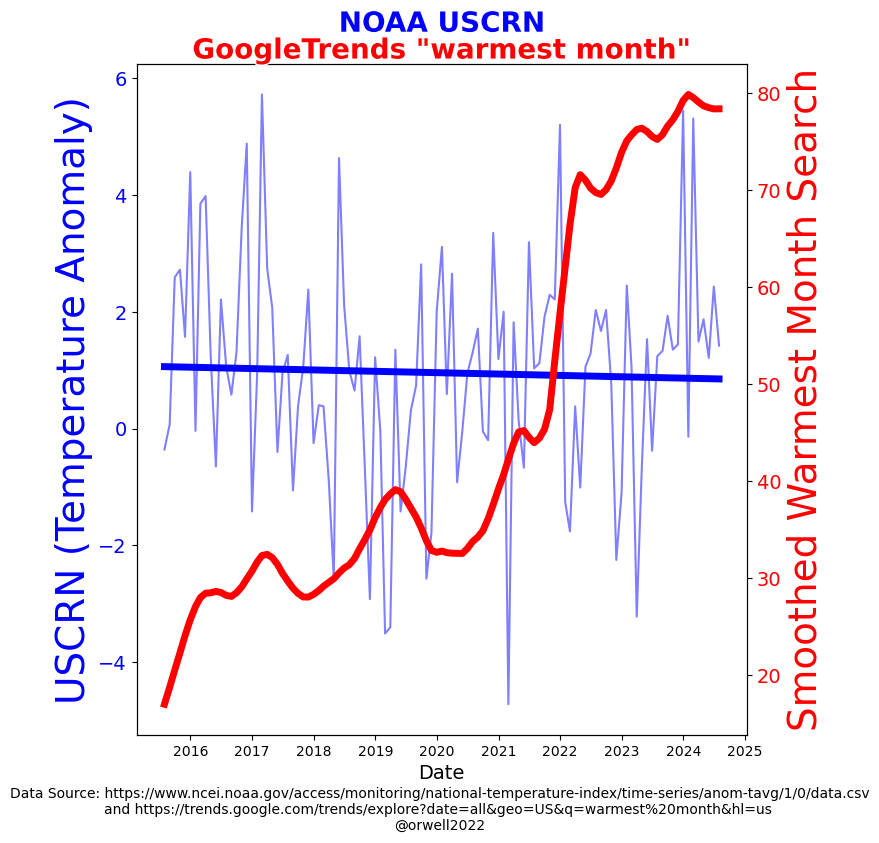

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pytrends.request import TrendReq
import requests
from io import StringIO
import matplotlib.patheffects as PathEffects

# Function to fetch NOAA data
def fetch_noaa_data():
    noaa_url = "https://www.ncei.noaa.gov/access/monitoring/national-temperature-index/time-series/anom-tavg/1/0/data.csv"
    response = requests.get(noaa_url)
    noaa_data = pd.read_csv(StringIO(response.text))

    noaa_data.columns = noaa_data.columns.str.strip()
    noaa_data = noaa_data.reset_index()
    noaa_data.columns = ['Date', 'ClimDiv', 'USCRN']
    noaa_data = noaa_data.iloc[1:]
    noaa_data['Date'] = pd.to_datetime(noaa_data['Date'], format='%Y%m')
    noaa_data = noaa_data[['Date', 'USCRN']]
    noaa_data['USCRN'] = pd.to_numeric(noaa_data['USCRN'], errors='coerce')
    noaa_data = noaa_data.dropna(subset=['USCRN'])
    noaa_data_monthly = noaa_data.set_index('Date').resample('M').mean()
    
    return noaa_data_monthly

# Function to fetch Google Trends data
def fetch_google_trends_data():
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = ["warmest month"]
    pytrends.build_payload(kw_list, geo='US', timeframe='all')
    trends_data = pytrends.interest_over_time()
    trends_data = trends_data.reset_index()
    trends_data = trends_data[['date', 'warmest month']]
    trends_data.columns = ['Date', 'Warmest Month Search']
    trends_data['Date'] = pd.to_datetime(trends_data['Date'])
    google_trends_monthly = trends_data.set_index('Date').resample('M').mean()
    
    return google_trends_monthly

# Fetch the data
noaa_data_monthly = fetch_noaa_data()
google_trends_monthly = fetch_google_trends_data()

# Merge NOAA and Google Trends data on date
merged_data = pd.merge(noaa_data_monthly, google_trends_monthly, left_index=True, right_index=True)

# Filter the data from July 2015 onwards
filtered_data = merged_data.loc['2015-07-01':]

# Apply LOESS smoothing to the Google Trends series
lowess_search = sm.nonparametric.lowess(filtered_data['Warmest Month Search'], np.arange(len(filtered_data)), frac=0.1)
smoothed_search = lowess_search[:, 1]

# Calculate the linear trend for the USCRN data
x = np.arange(len(filtered_data))
y = filtered_data['USCRN']
linear_trend = np.polyfit(x, y, 1)  # Fit a linear model (degree 1)
linear_trend_line = np.polyval(linear_trend, x)  # Evaluate the linear trend

# Create the plot with a 4:4 aspect ratio
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the original USCRN data
ax1.plot(filtered_data.index, filtered_data['USCRN'], color='blue', label='USCRN (Temperature Anomaly)', alpha=0.5)
ax1.plot(filtered_data.index, linear_trend_line, color='blue', linewidth=5, label='Linear Trend (USCRN)')
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('USCRN (Temperature Anomaly)', color='blue', fontsize=28)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)

# Create a second y-axis to plot the smoothed Google Trends data
ax2 = ax1.twinx()
ax2.plot(filtered_data.index, smoothed_search, color='red', linewidth=5, label='Smoothed Warmest Month Search')
ax2.set_ylabel('Smoothed Warmest Month Search', color='red', fontsize=28)
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)

# Set the title with colored and bold parts using PathEffects
title = 'NOAA USCRN'
title_perception = 'GoogleTrends "warmest month"'

# Add title part 1
t1 = plt.text(0.5, 1.06, title, color='blue', weight='bold', ha='center', va='center', transform=ax1.transAxes, fontsize=20)
t1.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="white")])

# Add title part 3
t3 = plt.text(0.5, 1.02, title_perception, color='red', weight='bold', ha='center', va='center', transform=ax1.transAxes, fontsize=20)
t3.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="white")])

fig.tight_layout()

# Shift the footnote down slightly
plt.figtext(0.5, -0.04, '\n\nData Source: https://www.ncei.noaa.gov/access/monitoring/national-temperature-index/time-series/anom-tavg/1/0/data.csv\nand https://trends.google.com/trends/explore?date=all&geo=US&q=warmest%20month&hl=us \n@orwell2022',
            ha="center", fontsize=10, color="black")

plt.show()
